6 bases
inputs: (2000, 4)
filters: (50, 4)
y: (2000,)


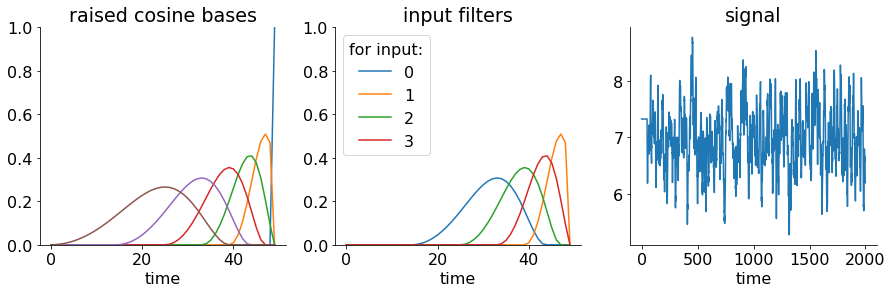

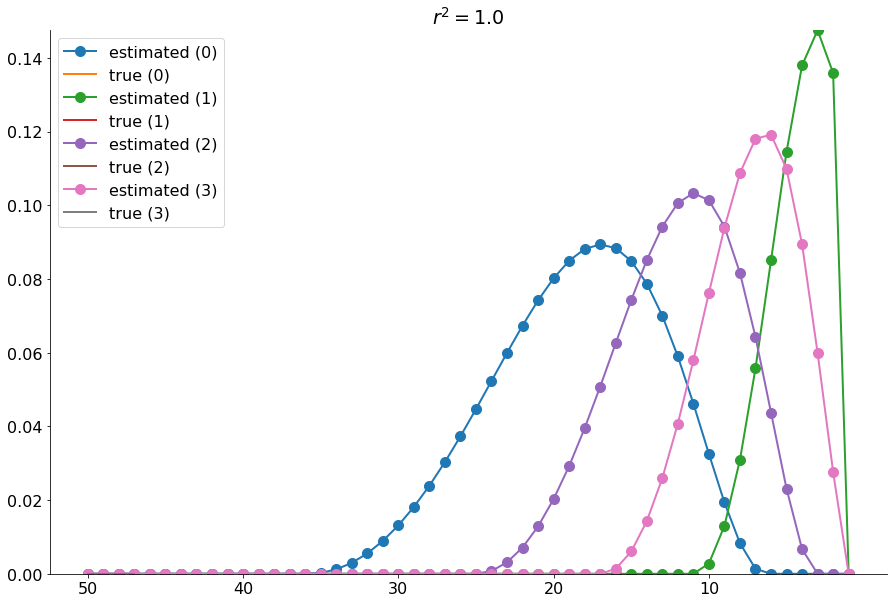

In [1]:
from glm_utils.preprocessing import time_delay_embedding, BasisProjection
import glm_utils.bases
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model as lm
plt.rcParams['font.size'] = 16

# TODO: explain in different boxes, with "story", including how it would look without normalization 
# TODO: add an example with extra inputs that where not used to construct the signal
# TODO: add an example for redundant variables
# TODO: simplify plotting code, to make it easy to read
# TODO: fix colors of plots to match according to related input
# TODO: example with a more complex filter, not exactly the same as the bases
# TODO: option to add some noise to play around with signal to noise ratio
# TODO: add plot comparing "relevance" of each input to the model (compare coefficients/filter-magnitudes)

# define bases
B = glm_utils.bases.raised_cosine(1, 5, [1, 23], 9)
window_size = B.shape[0]    # 50
nbases = B.shape[1]
basis_projection = BasisProjection(B)
print(f"{nbases} bases")
plt.figure(figsize=[15,4])
plt.subplot(131)
plt.plot(B)
plt.ylim([0,1])
plt.title('raised cosine bases')
plt.xlabel('time')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# define toy inputs (stimuli)
ninputs = 4
npoints = 2000
inputs_x = np.random.random((npoints, ninputs))
print(f"inputs: {inputs_x.shape}")

# define toy filters
filter_choice = [4,1,3,2]
filters = B[:,filter_choice]
print(f"filters: {filters.shape}")
plt.subplot(132)
plt.plot(filters)
plt.title('input filters')
plt.xlabel('time')
plt.ylim([0,1])
plt.legend(np.arange(ninputs), title='for input:')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# create toy signal from toy inputs and filters
y = np.zeros((npoints,),dtype=float)
for ii in range(ninputs):
    X = time_delay_embedding(x=inputs_x[:,ii], window_size=window_size)
    X = np.concatenate((np.ones((window_size,*X.shape[1:]))*X[0,0],X), axis=0)
    y = y + np.dot(X, filters[:,ii])
print(f"y: {y.shape}")
plt.subplot(133)
plt.plot(y)
plt.title('signal')
plt.xlabel('time')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

# scale inputs used to create the signal to simulate that we don't know the correct scale of each input
x_scales = np.array([1, 0.1, 4, 1])
scaled_inputs_x = inputs_x*x_scales

# normalize each input, this will fix for any scale and let us compare the filters/coefficients reconstructed for each input
for ii in range(ninputs):
    input_mean = np.nanmean(scaled_inputs_x[:,ii])
    input_std = np.nanstd(scaled_inputs_x[:,ii])
    scaled_inputs_x[:,ii] = (scaled_inputs_x[:,ii] - input_mean)/input_std

# choose how many random samples to take from the data (less or equal than the available data, npoints)
nsamples = 1000
sample_idxs = np.random.choice(np.arange(npoints),nsamples,replace=False)

# sample signal
y = y[sample_idxs]

# project inputs and then sample
Xs_b = np.empty((nsamples,0,nbases),dtype=float)
for ii in range(ninputs):
    # time-delay-embedding
    X = time_delay_embedding(scaled_inputs_x[:,ii], window_size=window_size)
    X = np.concatenate((np.ones((window_size,*X.shape[1:]))*X[0,0],X), axis=0) # this is fixing for the first missing elements
    # project
    X_b = basis_projection.transform(X)
    # sample
    X_b = X_b[sample_idxs]
    Xs_b = np.concatenate((Xs_b,X_b[:,np.newaxis,:]),axis=1)

# train model with sampled inputs and signal
lm_lr = lm.LinearRegression()
lm_lr.fit(np.reshape(Xs_b,(nsamples,-1)), y) # Xs_b has to be reshaped to be [nsamples, (nbases x ninputs)]
basis_weights = lm_lr.coef_

# reconstruct filters from models coefficients
estimated_filters = np.empty((0,window_size),dtype=float)
for ii in range(ninputs):
    ifilter = basis_projection.inverse_transform(basis_weights[ii*nbases:(ii+1)*nbases,np.newaxis].T)
    estimated_filters = np.concatenate((estimated_filters,ifilter),axis=0)

# plot true filters and reconstructed filters for all inputs
plt.figure(figsize=[15,10])
for ii in range(ninputs):
    plt.plot(estimated_filters[ii,:].T, 'o-', linewidth=2, markersize=10, label=f'estimated ({ii})')
    plt.plot(filters[ii], linewidth=2, label=f'true ({ii})')
    plt.ylim([estimated_filters.min(),estimated_filters.max()])
    plt.xticks([])
    if ii == 0:
        plt.title(f'$r^2={lm_lr.score(np.reshape(Xs_b,(nsamples,-1)), y):1.2}$')        
plt.legend()
plt.xticks(np.arange(window_size)[::10],np.arange(window_size+1)[::-10])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()